# task 1: Hybrid image

Using low-pass filter on image A and high-pass filter on image B

Then add then together.


Procedure:

1. multiply the input image by $(-1)^{x+y} $ to center the transform

2. compute FT of input image => get the freq img

3. Multiply the filter

4. compute inverse FT => get the time img

5. multiply by $(-1)^{x+y}$

In [1]:
import imageio
from PIL import Image
import scipy.fftpack as fp
from scipy.signal import convolve2d
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def give_me_freq(img):
    result_img = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            result_img[i, j] = img[i, j] * (-1)**(i+j)
    return fp.fft2(result_img)

In [3]:
def give_me_time(freq):
    img = fp.ifft2(freq)
    result_img = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):        
            result_img[i, j] = img[i, j] * (-1)**(i+j)
    return result_img

In [4]:
def low_pass_filter(img, r=40, filter_type='ideal'):
    low_pass_img = np.zeros(shape=img.shape)
    center = low_pass_img.shape[0] // 2, low_pass_img.shape[1] // 2    
    for i in range(low_pass_img.shape[0]):
        for j in range(low_pass_img.shape[1]):
            if filter_type == 'gaussian':
                c = -1.0 * ((i - center[0])**2 + (j - center[1])**2) / (2 * r**2)
                #print(c)
                low_pass_img[i, j] = np.exp(c)
                #print(math.exp(-(((i-center[0])**2 + (j-center[1])**2) / 2*r**2)))
            elif filter_type == 'ideal':
                if (i-center[0])**2 + (j-center[1])**2 < r**2:
                    low_pass_img[i, j] = 1
    return low_pass_img

In [5]:
def high_pass_filter(img, r=40, filter_type='ideal'):
    high_pass_img = np.zeros(shape=img.shape)
    center = high_pass_img.shape[0] / 2, high_pass_img.shape[1] / 2
    for i in range(high_pass_img.shape[0]):
        for j in range(high_pass_img.shape[1]):
            if filter_type == 'gaussian':
                c = -1.0 * ((i - center[0])**2 + (j - center[1])**2) / (2 * r**2)
                #print(c)
                high_pass_img[i, j] = 1 - np.exp(c)
                #print(math.exp(-(((i-center[0])**2 + (j-center[1])**2) / 2*r**2)))
            elif filter_type == 'ideal':
                if (i-center[0])**2 + (j-center[1])**2 > r**2:
                    high_pass_img[i, j] = 1
    return high_pass_img

In [6]:
def filter_img(fname, freq='low', filter_type='ideal', r=20, gray=True):
    if gray == True:
        img_arr = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        img_freqs = [give_me_freq(img_arr)]
    else:
        img_arr = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        img_freqs = [give_me_freq(img_arr[:,:,i]) for i in range(img_arr.shape[2])]
    img_freq = give_me_freq(img_arr)
    if freq == 'low':
        filtered_freqs = [np.multiply(low_pass_filter(i, r, filter_type), i) for i in img_freqs]
    else:
        filtered_freqs = [np.multiply(high_pass_filter(i, r, filter_type), i) for i in img_freqs]
    filtered_imgs = [give_me_time(i) for i in filtered_freqs]
    filtered_imgs = [np.nan_to_num(i, 0) for i in filtered_imgs]
    filtered_imgs = [i / max(i.flatten()) for i in filtered_imgs]
    filtered_imgs = [np.sqrt(i**2) for i in filtered_imgs]
    return np.dstack(filtered_imgs)

In [7]:
def hybrid_img(img_low='task1and2_hybrid_pyramid/dog.bmp', img_high='task1and2_hybrid_pyramid/cat.bmp',
               save_name='mixed.png', gray=True, filter_type='gaussian', r=20):
    img1 = filter_img(img_low, 'low', 'gaussian', r=r, gray=gray)
    img2 = filter_img(img_high, 'high', 'gaussian', r=r, gray=gray)
    result_img = np.real(img1 + img2) / 2
    imageio.imsave(save_name, result_img)

In [9]:
hybrid_img()

/Users/goldflower/.pyenv/versions/3.6.3/envs/env_3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  
/Users/goldflower/.pyenv/versions/3.6.3/envs/env_3.6.3/lib/python3.6/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


# task2: image pyramid

In [10]:
def create_kernel(nb_rows=3, nb_cols=3, r=1.5):
    center = nb_rows // 2, nb_cols // 2
    kernel = np.zeros(shape=(nb_rows, nb_cols))
    for i in range(nb_rows):
        for j in range(nb_cols):
            c = -1.0 * ((i - center[0])**2 + (j - center[1])**2) / (2 * r**2)
            #print(c)
            kernel[i, j] = np.exp(c)               
    return kernel / np.sum(kernel.flatten())

In [11]:
def reduce(img, kernel):
    reduced = convolve2d(img, kernel, 'same')
    #reduced = convolve2d(img, kernel, 'same')
    reduced = reduced[::2, ::2]
    return reduced

In [12]:
def expand(img, kernel):
    expanded = np.zeros((img.shape[0]*2, img.shape[1]*2))
    expanded[::2, ::2] = img
    expanded[1::2, 1::2] = img
    #expanded = convolve2d(expanded, kernel, 'same')
    expanded = convolve2d(expanded, kernel, 'same')
    return expanded

In [13]:
def gaussian_pyramid(img, levels=5, kernel=None):
    pyramid_list = []
    current_img = img
    for i in range(levels):
        reduced = reduce(current_img, kernel)
        pyramid_list.append(reduced)
        current_img = reduced
    return pyramid_list

In [14]:
def laplacian_pyramid(pyramid_list, kernel=None):
    laplacian_pyramid_list = []
    for i in range(len(pyramid_list)-1):
        expanded = expand(pyramid_list[i+1], kernel)
        reconstructed = pyramid_list[i] - expanded[:pyramid_list[i].shape[0],
                                                   :pyramid_list[i].shape[1]]
        laplacian_pyramid_list.append(reconstructed)
    laplacian_pyramid_list.append(pyramid_list[-1])
    return laplacian_pyramid_list

In [15]:
img_ori = imageio.imread('task1and2_hybrid_pyramid/dog.bmp')

In [16]:
img_arr = cv2.imread('task1and2_hybrid_pyramid/dog.bmp', cv2.IMREAD_GRAYSCALE)

In [17]:
kernel = create_kernel(5, 5, 1.5)
gs = gaussian_pyramid(img_arr, 5, kernel)
ls = laplacian_pyramid(gs, kernel)

In [18]:
gs_freq = [give_me_freq(im) for im in gs]
ls_freq = [give_me_freq(im) for im in ls]

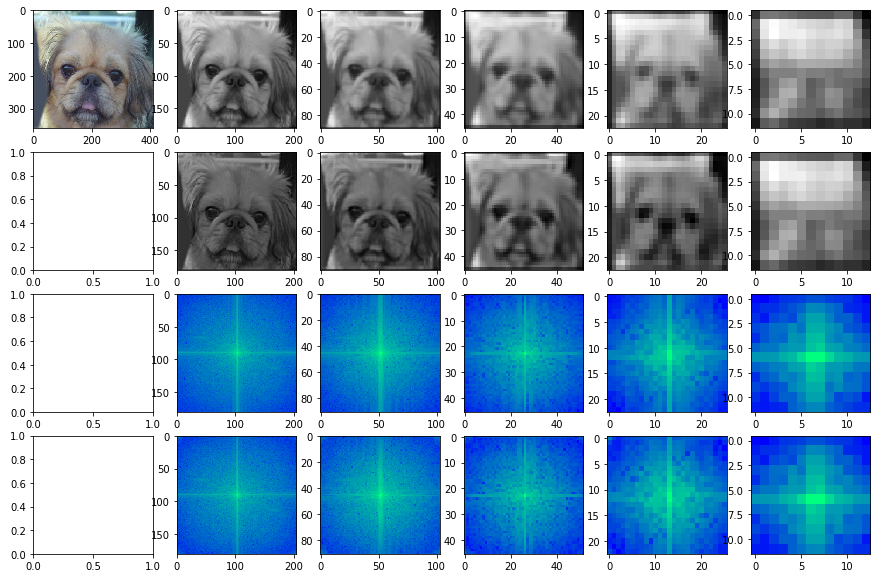

In [22]:
_, axarr = plt.subplots(4,6, figsize=(15,10))
aspect = 'auto'
cmap='winter'

axarr[0,0].imshow(img_ori, aspect=aspect)
for i in range(1, len(gs)+1):
    axarr[0, i].imshow(gs[i-1], cmap='gray', aspect=aspect)
    axarr[1, i].imshow(ls[i-1], cmap='gray', aspect=aspect)
    axarr[2, i].imshow(np.log10(abs(gs_freq[i-1])), cmap=cmap, aspect=aspect)
    axarr[3, i].imshow(np.log10(abs(ls_freq[i-1])), cmap=cmap, aspect=aspect)
plt.savefig('pyramid.png')    
plt.show()
plt.close()